We refer to __Time Series__ when we deal with numeric data indexed by time. Let's look at the _Monthly car sales in Quebec 1960-1968_. This dataset can be obtained from 

<https://datamarket.com/data/set/22n4/monthly-car-sales-in-quebec-1960-1968>

So let's read data. We will have to clean it a bit.

In [1]:
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

In [3]:
cars_df = pd.read_csv("data/car_sales/monthly-car-sales-in-quebec-1960.csv")
cars_df.tail()

,Month,Monthly car sales in Quebec 1960-1968
104,1968-09,14385.0
105,1968-10,21342.0
106,1968-11,17180.0
107,1968-12,14577.0
108,Monthly car sales in Quebec 1960-1968,NaN


So we need to remove the last row

In [4]:
cars_df = cars_df.iloc[:-1]

Let's change it into datetime format for nicer plots.

In [5]:
cars_df["dt"] = cars_df["Month"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m'))

Rename the long name in column `Monthly car sales in Quebec 1960-1968` for just `sales` and drop the column `Month`.

In [6]:
cars_df = cars_df\
    .rename({"Monthly car sales in Quebec 1960-1968": "sales"}, axis=1)\
    .drop("Month", axis=1)
cars_df.tail()

,sales,dt
103,16722.0,1968-08-01
104,14385.0,1968-09-01
105,21342.0,1968-10-01
106,17180.0,1968-11-01
107,14577.0,1968-12-01


And finally let's plot it.

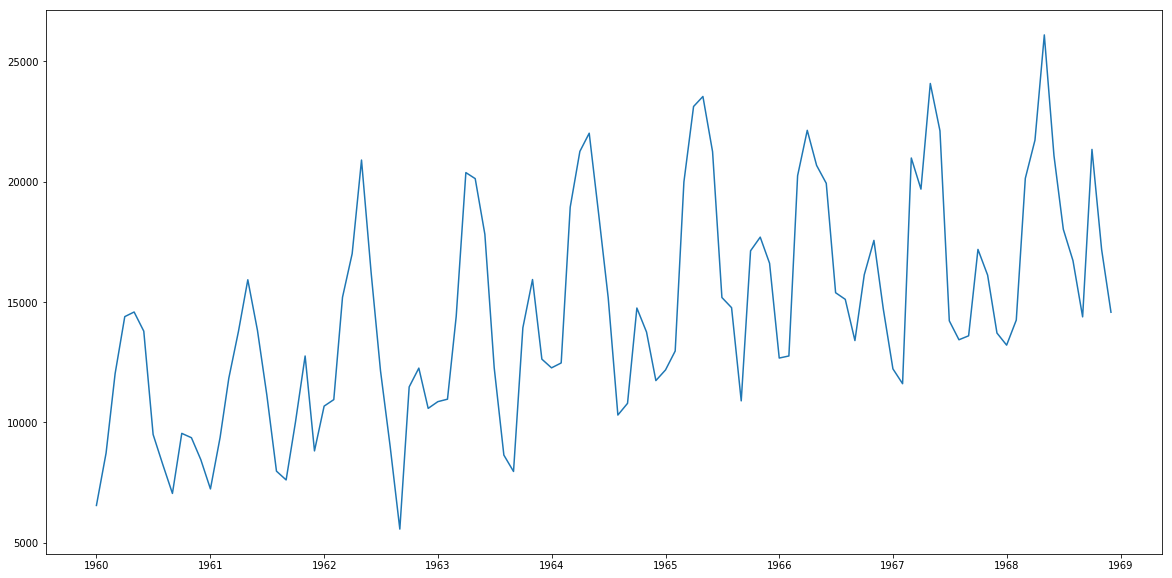

In [7]:
plt.plot(cars_df["dt"], cars_df["sales"])
plt.show()

Let's check if there is no missing data. For example, let's check if each year has 12 months.

In [8]:
cars_df[['dt']].groupby(cars_df["dt"].dt.year).count()

,dt
dt,
1960,12
1961,12
1962,12
1963,12
1964,12
1965,12
1966,12
1967,12
1968,12


## Problem


We would like to build an algorithm that forecast future sales.

## Train - dev - test split

Here we cannot do random splitting later we will explain why. Our split should be based on time. Why is that?

* Our objective is to forecast the future sales. So if we train with data that are posterior to test data, we are using time machine. This is a common mistakes. Algorithm train and test like that tends to have excellent score on test set, but in practice have very bad performance. 

In [9]:
Xy = cars_df[['dt', 'sales']]

def create_X_and_y(Xy, target_column='sales'):
    return Xy.drop(target_column, axis=1), Xy[target_column]

def split_into_train_dev_test(Xy):
    X_train, y_train = create_X_and_y(Xy.query("dt < '1967'"))
    X_dev, y_dev = create_X_and_y(Xy.query("dt >= '1967' and dt < '1968'"))
    X_test, y_test = create_X_and_y(Xy.query("dt >= '1968'"))
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy)

## Simplest prediction: average of previous sales

The simplest prediction is just average of the previous sales. Let's calculate it.

In [10]:
y_dev_hat = np.ones(len(y_dev)) * y_train.mean()

And then we can plot its performance.

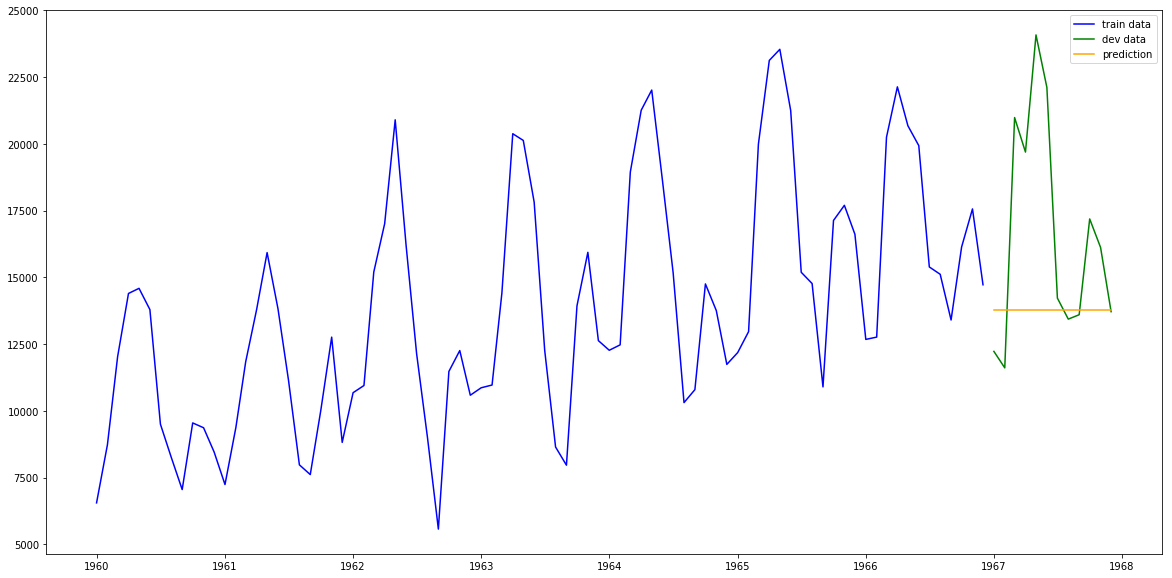

In [11]:
def plot_prediciton(X_train, y_train, X_dev, y_dev, y_dev_hat):
    plt.plot(X_train["dt"], y_train, c="blue", label='train data')
    plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
    plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
    plt.legend()
    plt.show()
    
plot_prediciton(X_train, y_train, X_dev, y_dev, y_dev_hat)

We see that this is not very good prediction. However, we will use it as our __baseline__, that is a starting point for further improvments. For that let's calculate mean square error (MSE) and root of mean square error (RMSE) which will serve us for comparation with better predictions.

In [13]:
from sklearn.metrics import mean_squared_error

print("MSE: " ,mean_squared_error(y_dev, y_dev_hat))
print("RMSE: ", np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

MSE:  23847172.57993197
RMSE:  4883.356691859808


## Average of the previous year

So let's take the last 12 values and calculate mean.

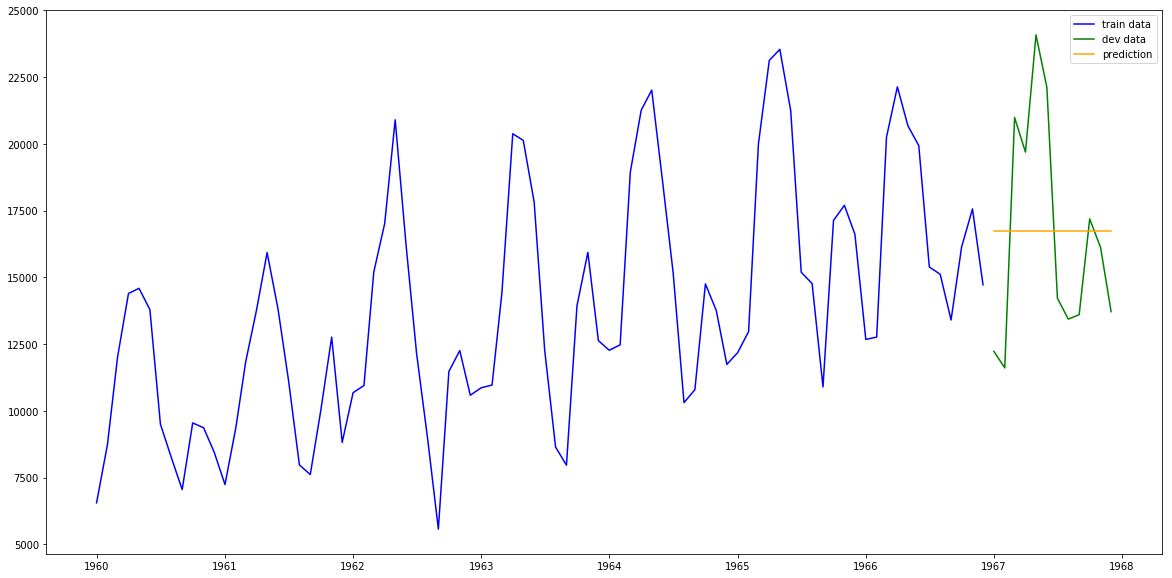

In [14]:
y_dev_hat = np.ones(len(y_dev)) * y_train[-12:].mean()
plot_prediciton(X_train, y_train, X_dev, y_dev, y_dev_hat)

This time it looks better.

In [15]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4011.3046791744287

So we have also improved RMSE.

## Taking advantage of knowing previous month

Often, we know the value for the previous month and we want to predict just the next month. For this we add to our feature set $X$ the value of the previous month. For that we have python method `shift`. Any previous value is called __lag__.

In [16]:
Xy_with_lags = Xy.copy()
Xy_with_lags['sales-1'] = Xy_with_lags['sales'].shift(1)
Xy_with_lags.head()

,dt,sales,sales-1
0,1960-01-01,6550.0,NaN
1,1960-02-01,8728.0,6550.0
2,1960-03-01,12026.0,8728.0
3,1960-04-01,14395.0,12026.0
4,1960-05-01,14587.0,14395.0


In [17]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

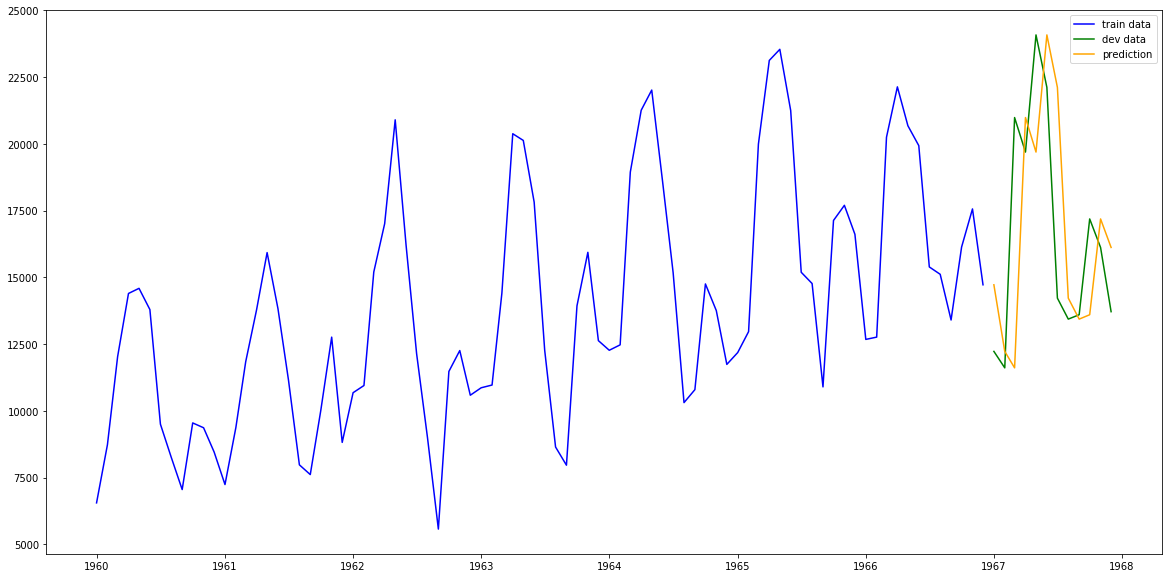

In [18]:
y_dev_hat = X_dev['sales-1']
plot_prediciton(X_train, y_train, X_dev, y_dev, y_dev_hat)

In [19]:
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

4103.945367976203

## Autocorrelation and Autoregression (AR)

It is clear that data there is some relation between values for December 1966 and December 1965. In order to detect them we can calculate correlation with __lags__ of the sales. Let's see how we can do this. 

In [20]:
N_lags = 12

def create_lags(Xy, n_lags):
    Xy_with_lags = Xy.copy()
    for i in range(1, n_lags+1):
        Xy_with_lags['sales-'+str(i)] = Xy_with_lags['sales'].shift(i)
    return Xy_with_lags

Xy_with_lags = create_lags(Xy, N_lags)
autocorrelations = Xy_with_lags.iloc[N_lags:].drop("dt", axis=1).corr()['sales']

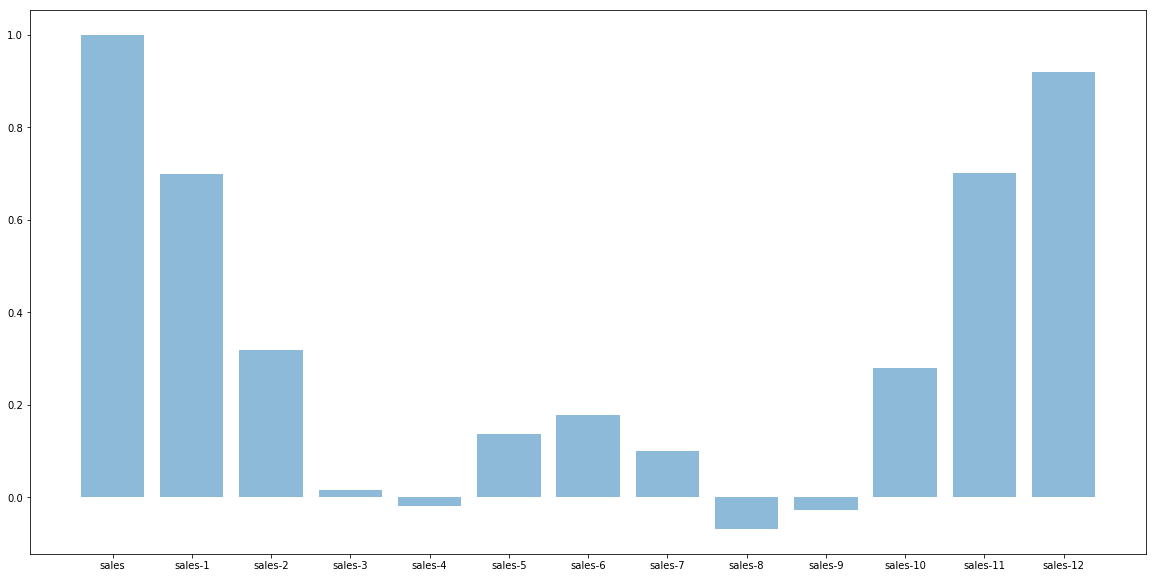

In [21]:
plt.bar(autocorrelations.index, autocorrelations, align='center', alpha=0.5)
plt.show()

Now we will choose columns that are highly correlated with `sales`.

In [22]:
columns_for_ar = autocorrelations[np.abs(autocorrelations) > 0.15].index[1:]
columns_for_ar

Index(['sales-1', 'sales-2', 'sales-6', 'sales-10', 'sales-11', 'sales-12'], dtype='object')

At the begning of our dataser we have lots of `NaN`s. Let's remove them.

In [23]:
Xy_with_lags.head()

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
0,1960-01-01,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1960-02-01,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1960-03-01,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1960-04-01,14395.0,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1960-05-01,14587.0,14395.0,12026.0,8728.0,6550.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
Xy_with_lags = Xy_with_lags.iloc[N_lags:].reset_index(drop=True)
Xy_with_lags.head()

,dt,sales,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7,sales-8,sales-9,sales-10,sales-11,sales-12
0,1961-01-01,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0,6550.0
1,1961-02-01,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0,8728.0
2,1961-03-01,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0,12026.0
3,1961-04-01,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0,14395.0
4,1961-05-01,15926.0,13784.0,11837.0,9374.0,7237.0,8456.0,9364.0,9545.0,7049.0,8251.0,9498.0,13791.0,14587.0


In [29]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

from sklearn.linear_model import LinearRegression

def train_and_test_linear_model(X_train, y_train, X_dev, y_dev):
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_dev_hat = reg.predict(X_dev)
    return reg, np.sqrt(mean_squared_error(y_dev, y_dev_hat))


reg, rmse = train_and_test_linear_model(
    X_train.drop("dt", axis=1)[columns_for_ar], y_train, 
    X_dev.drop("dt", axis=1)[columns_for_ar], y_dev)

y_dev_hat = reg.predict(X_dev.drop("dt", axis=1)[columns_for_ar])
rmse

2014.6596936086883

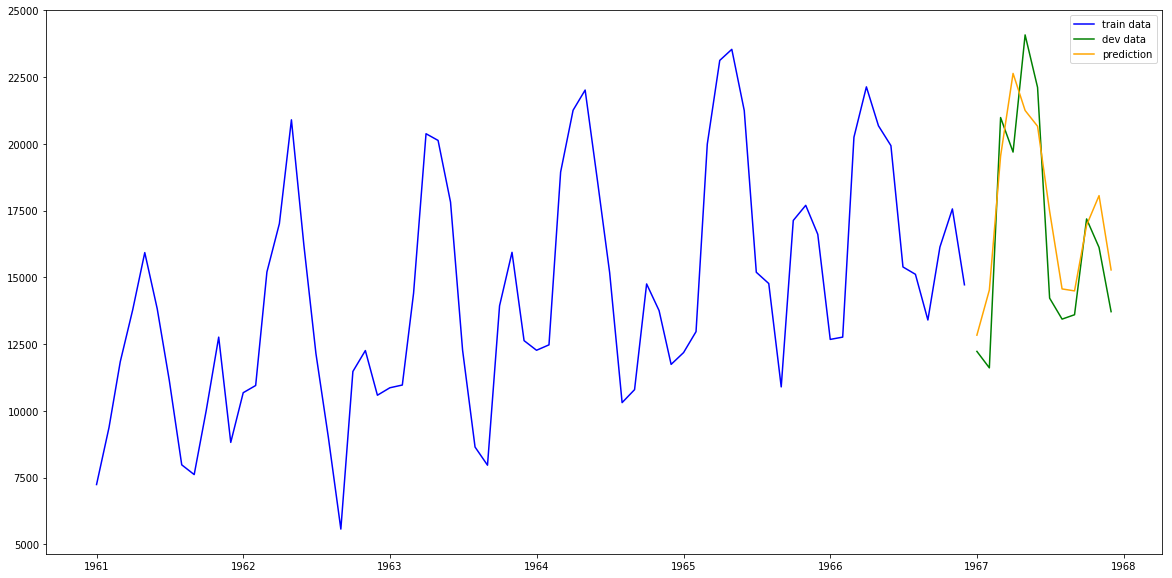

In [30]:
plot_prediciton(X_train, y_train, X_dev, y_dev, y_dev_hat)

We have improved the performance twice!

We can also use all 12 columns. Sometimes it works well, sometimes not.

In [31]:
columns_for_ar = ["sales-" + str(i) for i in range(1, 13)]

reg_all_columns, rmse = train_and_test_linear_model(
    X_train.drop("dt", axis=1)[columns_for_ar], y_train, 
    X_dev.drop("dt", axis=1)[columns_for_ar], y_dev)

rmse

2009.4533750232415

So this time better, Nice.

However very often in practice we would like to predict the sales for entire year. So let's assume that we are in January 1967 and what to forecast our sales for 1967 monthly. This way the company would know how to optimize stocks for each month. However, this means that when we predict the value for April we do not know what is real value for January, February and March. So what we will predict the sales for January and than use this as a feature for predicting February. And so on. Let's see how we are going to program that.

In [32]:
def recurrent_prediction(y_train, n_steps, reg):
    x_dev = list(y_train[-1:-(n_steps +1):-1])
    y_dev_hat = []
    for i in range(n_steps):
        y_hat = reg.predict([x_dev])[0]
        y_dev_hat.append(y_hat)
        x_dev.pop(-1)
        x_dev = [y_hat] + x_dev
    return y_dev_hat

y_dev_hat = recurrent_prediction(y_train, 12, reg_all_columns)
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1894.0145703758449

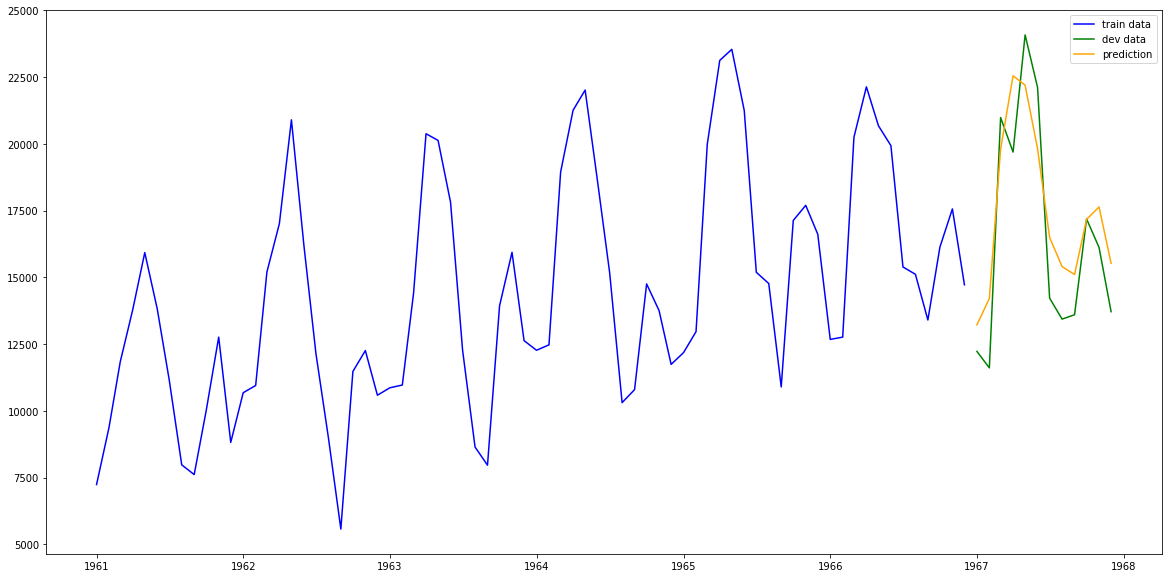

In [33]:
plot_prediciton(X_train, y_train, X_dev, y_dev, y_dev_hat)

We can even go further and train 12 models, that predict future data.

In [34]:
N_models = 12
N_lags = 12

Xy_with_lags = create_lags(Xy, N_lags + N_models - 1).iloc[N_lags + N_models - 1:]

X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

In [35]:
N_models = 12
N_lags = 12

Xy_with_lags = create_lags(Xy, N_lags + N_models - 1).iloc[N_lags + N_models - 1:]

X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

def train_n_models(n_models, n_lags, X_train, y_train):
    regs = []
    for i in range(1, n_models + 1):
        reg = LinearRegression().fit(X_train.iloc[:, range(i, i+n_lags)], y_train)
        regs.append(reg)
    return regs

def predict_n_models(regs, n_lags, X_dev):
    y_hats = []
    for i in range(1, len(regs) + 1):
        y_hats.append(regs[i-1].predict(X_dev.iloc[[i-1], range(i, i+n_lags)]))
    return np.concatenate(y_hats)

regs = train_n_models(N_models, N_lags, X_train, y_train)
y_dev_hat = predict_n_models(regs, N_lags, X_dev)
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1954.2375844107753

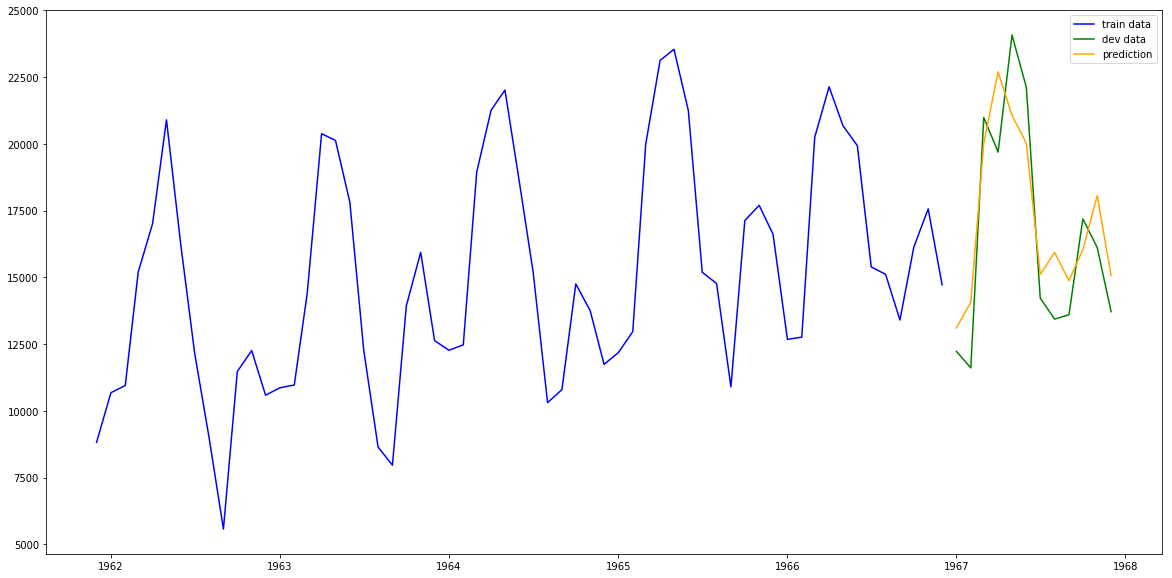

In [36]:
plot_prediciton(X_train, y_train, X_dev, y_dev, y_dev_hat)

## K-nearest neighborhood 

In [47]:
from sklearn.neighbors import KNeighborsRegressor

N_lags = 12
Xy_with_lags = create_lags(Xy, N_lags).iloc[N_lags:]
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

reg_kn = KNeighborsRegressor(n_neighbors=5)
reg_kn.fit(X_train.drop("dt", axis=1), y_train)
y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1664.4863111482778

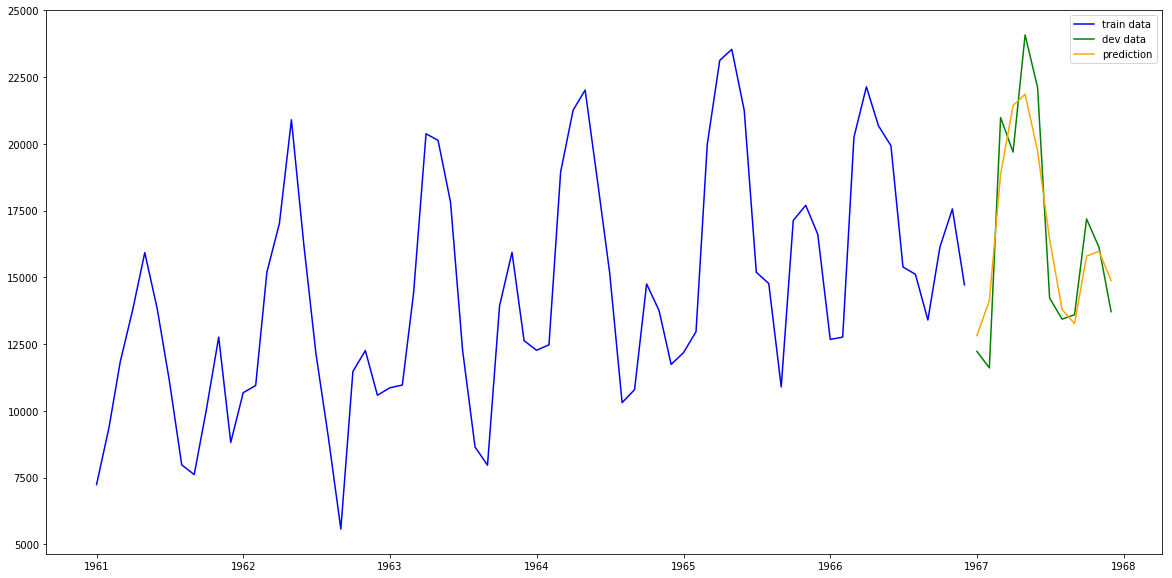

In [48]:
plot_prediciton(X_train, y_train, X_dev, y_dev, y_dev_hat)

### Grid search of best parameters

In [49]:
performance = pd.DataFrame()   

for n_neighbors in [2, 3, 4, 5, 6, 7, 8]:
    reg_kn = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg_kn.fit(X_train.drop("dt", axis=1), y_train)
    y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)
    rmse = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
    new_row = pd.DataFrame({
        "n_neighbours": [n_neighbors], 
        "rmse": [rmse]
    })
    performance = performance.append(new_row, ignore_index = True)
performance.sort_values("rmse").head()

,n_neighbours,rmse
0,2,1557.793197
2,4,1659.930914
3,5,1664.486311
6,8,1838.954597
1,3,1866.014777


## Random Forest

In [50]:
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


reg_rf = RandomForestRegressor(random_state=667)
reg_rf.fit(X_train.drop("dt", axis=1), y_train)
y_dev_hat = recurrent_prediction(y_train, N_lags, reg_rf)
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

1563.6772125346079

In [51]:
performance = pd.DataFrame()   

for n_estimators in [2, 5, 7, 10, 20, 100]:
    for max_depth in [5, 7, 10, 20]:
        reg_kn = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=667)
        reg_kn.fit(X_train.drop("dt", axis=1), y_train)
        y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)
        rmse = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
        new_row = pd.DataFrame({
            "n_estimators": [n_estimators], 
            "max_depth": [max_depth],
            "rmse": [rmse]
        })
        performance = performance.append(new_row, ignore_index = True)
performance.sort_values("rmse").head()

,max_depth,n_estimators,rmse
11,20,7,1515.355936
8,5,7,1519.197094
14,10,10,1555.179317
15,20,10,1563.677213
12,5,10,1576.342980


In [52]:
X_train_dev = pd.concat([X_train, X_dev])
y_train_dev = np.concatenate([y_train, y_dev])

reg_rf = RandomForestRegressor(n_estimators=7, max_depth=20, random_state=667)
reg_rf.fit(X_train_dev.drop("dt", axis=1), y_train_dev)
y_test_hat = recurrent_prediction(y_test, N_lags, reg_rf)
np.sqrt(mean_squared_error(y_test, y_test_hat))

2159.4251868854135

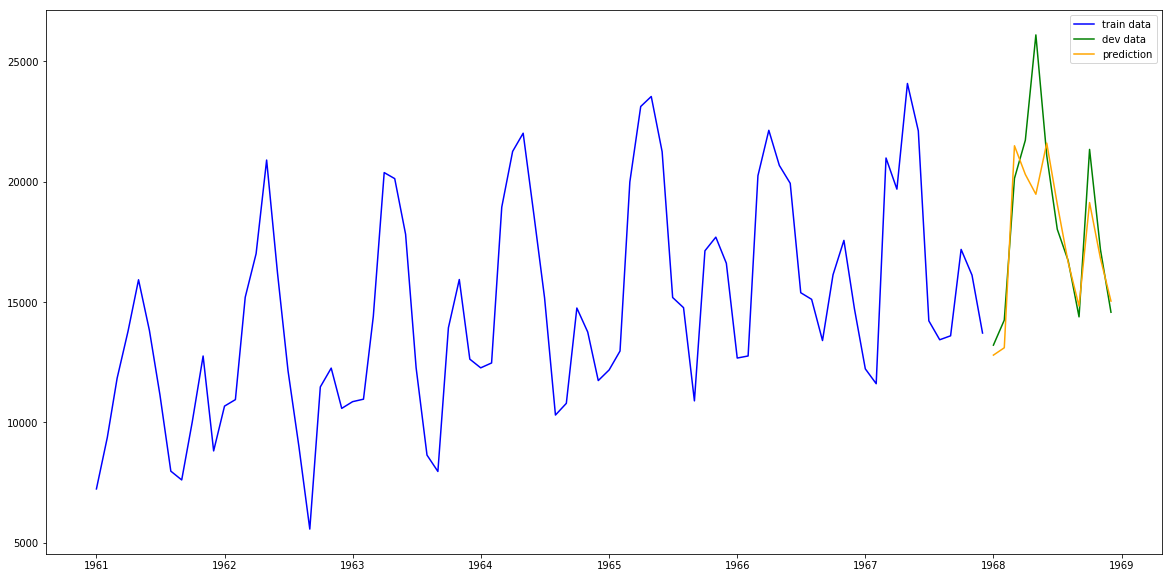

In [53]:
plot_prediciton(X_train_dev, y_train_dev, X_test, y_test, y_test_hat)

## Traditional Models: Autoregression (AR) and Autoregression Moving Average (ARMA)

###  Autoregression (AR) 

In [54]:
from statsmodels.tsa.ar_model import AR
model = AR(y_train)
model_fit = model.fit(maxlag=12)
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

1773.1012131860862


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


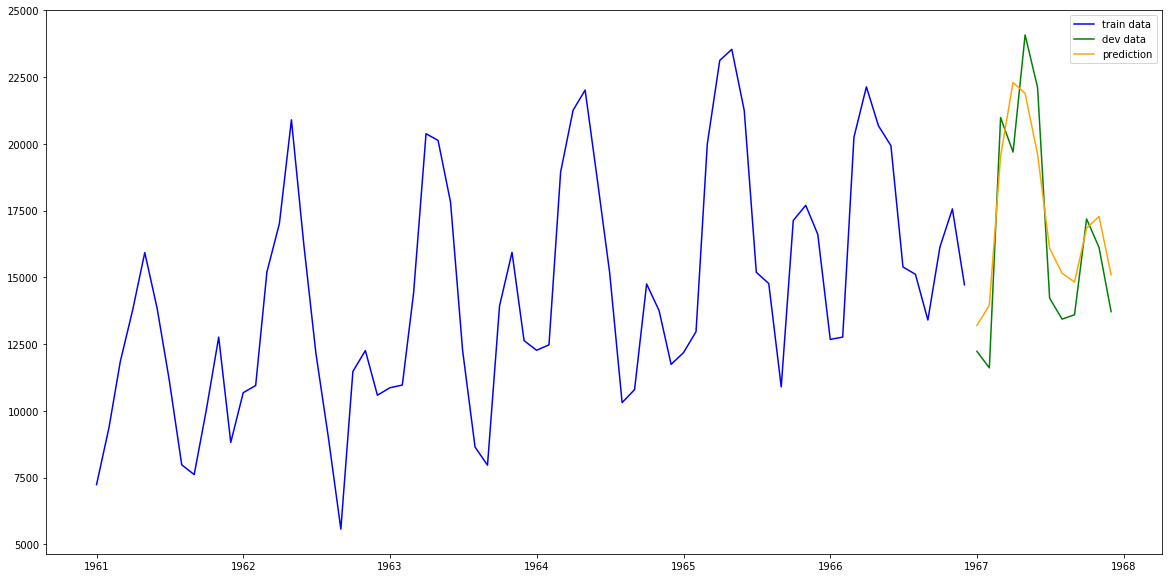

In [55]:
plot_prediciton(X_train, y_train, X_dev, y_dev, y_dev_hat)

In [56]:
model_fit = model.fit(maxlag=13)
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

1717.996621764539


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


## Traditional Model: Autoregression Moving Average

In [57]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(y_train, order=(9, 2))
model_fit = model.fit(disp=0, start_ar_lags=13)

/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [58]:
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

2501.305981229266


/home/bartek/Envs/py3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


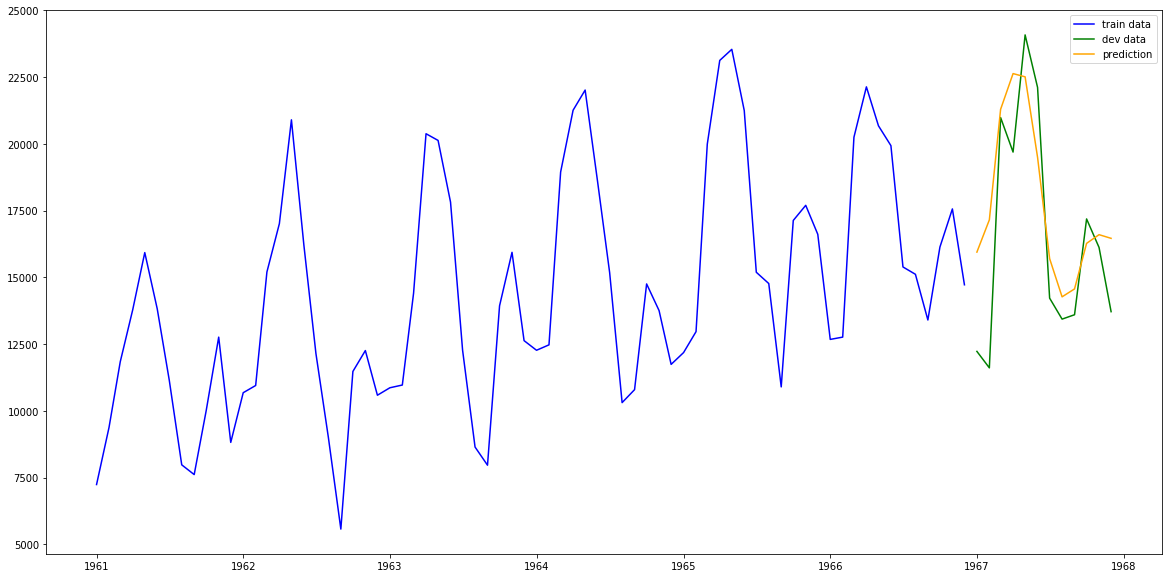

In [59]:
plot_prediciton(X_train, y_train, X_dev, y_dev, y_dev_hat)

## Exercise

Here we will use data from kaggle competition <https://www.kaggle.com/c/competitive-data-science-predict-future-sales>. We assume that you have downloaded and upzip them into directory `com`

So let's read data and aggregate them by day.

In [60]:
import datetime
sales = pd.read_csv("data/competitive-data-science-predict-future-sales/sales_train.csv.gz")
sales['date'] = sales['date'].apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
total_daily_sales = sales.groupby('date', as_index=False)[['item_cnt_day']].sum()

In [ ]:
total_daily_sales = sales.groupby('date', as_index=False)[['item_cnt_day']].sum()

Your objective is to predict total daily sales for last two week of November 2015. 

## Bibliography

https://machinelearningmastery.com/how-to-develop-a-skilful-time-series-forecasting-model/

https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc41.htm

https://www.it.uu.se/research/publications/reports/2006-022/2006-022-nc.pdf
http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
